In [8]:
import scipy.io.wavfile
from IPython.display import Audio
import soundfile as sf

import numpy as np
import matplotlib.pyplot as plt

In [350]:
def plot_signal0(x, k_lim = 440):
    x = x[:k_lim]
    plt.figure(figsize=[6, 4], dpi=120)
    k = np.arange(len(x))
    plt.plot(k, x, 'g')
    plt.xlabel("k")
    plt.ylabel("x[k]")
    plt.xlim([0, len(x)])
    plt.title("Signal x[k]")
    plt.grid()

def plot_signal(x, f, fs=44100):
    idx_period = (int)(fs / f)
    x = x[:idx_period]
    plt.figure(figsize=[6, 4], dpi=120)
    k = np.arange(len(x))
    plt.plot(k, x, 'g')
    plt.xlabel("k")
    plt.ylabel("x[k]")
    plt.xlim([0, len(x)])
    plt.title("Signal x[k]")
    plt.grid()

In [991]:
def gen_sample(periodic_func, A=1., f=440., phase_coef=0., fs=44100):
    assert(fs > 0 and fs <= 44100)
    assert(f < fs)
    assert(A >= 0. and A <= 1.)
    assert(phase_coef >= 0. and phase_coef <= 1.)
    k = np.arange(fs) / fs
    func = periodic_func(k, A, f, phase_coef)
    assert(len(func) == len(k))
    assert(np.max(func) <= 1. and np.min(func) >= 0.)
    return func

def sin_wave_1sec(k, A, f, phase_coef):
    return A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)

def sin_wave_1sec_dist(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    for i in range(len(wave)):
        if wave[i] > 0.95 * A:
            wave[i] = 0.95 * A
        elif wave[i] < 0.05 * A:
            wave[i] = 0.05 * A
    return wave

def sin_wave_1sec_dist2(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    for i in range(len(wave)):
        if wave[i] > 0.8 * A:
            wave[i] = 0.98 * wave[i]
        elif wave[i] < 0.2 * A:
            wave[i] = 1.02 * wave[i]
    return wave

def sin_wave_1sec_noise(k, A, f, phase_coef):
    wave = A * 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    r = np.random.normal(0, 0.01, len(k))
#     r = 0.02*np.sin(2*np.pi*k*5000)
    wave = wave + r
    for i in range(len(wave)):
        if wave[i] < 0.:
            wave[i] = 0.
        elif wave[i] > 1.:
            wave[i] = 1.
    return wave

def drum_wave(k, A, f, phase_coef):
    sig = np.zeros(len(k))
    f=1
    for i in range(len(k)):
        sig[i] = A * 0.5 * (np.sin(k[i]/len(k) * 2 * np.pi * f*1000 - 2 * np.pi * phase_coef) + 1)
        f = f - 0.0001
        if f < 0.:
            f = 0.
    return sig

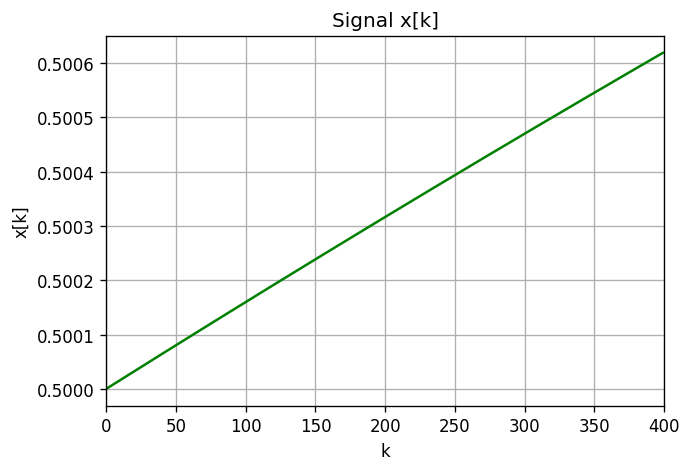

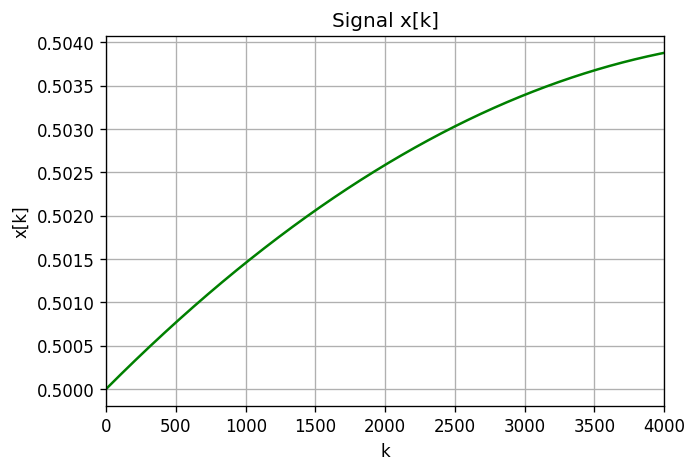

In [992]:
fs = 44100
f = 440 / 4
phase_coef = 0. # 0.25
A = 1
k = np.arange(fs) / fs # step
sin_wave = gen_sample(sin_wave_1sec, A, f, phase_coef, fs)
sin_wave2 = gen_sample(sin_wave_1sec, A, f * 3/2, phase_coef, fs)
sin_wave3 = gen_sample(sin_wave_1sec, A, f * 5/3, phase_coef, fs)
drum_wave = gen_sample(drum_wave, A, f, phase_coef, fs)
idx_period = int(fs / f) + 1
plot_signal(drum_wave, f, fs)
plot_signal0(drum_wave, 4000)

In [988]:
def gen_soundwave(sample, duration_ms, fs=44100):
    sound = np.array([])
    t = duration_ms / 1000.
    f0 = fs / len(sample)
    periods = (int)(t * f0)
    print(periods)
    print(len(sample))
    for i in range(periods):
        sound = np.concatenate((sound, sample), axis=None)
    return sound

def gen_soundwave2(sample, duration_ms, rise, decay, fs=44100):
    assert(rise >= 0. and rise <= 1.)
    assert(decay >= 0. and decay <= 1.)
    k_max = (int)(duration_ms / 1000. * fs)
    front = (np.arange(k_max) / (k_max * rise))**2
    back = ((k_max - np.arange(k_max)) / (k_max * decay))**2
    for i in range(k_max):
        if front[i] > 1.:
            front[i] = 1.
        if back[i] > 1.:
            back[i] = 1.
    
    sound = np.zeros(k_max)
    assert(len(front) == len(sound))
    for i in range(k_max):
        sound[i] = sample[i % len(sample)] * front[i] * back[i]
    return sound

In [976]:
sample = (drum_wave) / 2
sound = gen_soundwave2(sample, 16000, 0.1, 0.2, fs)

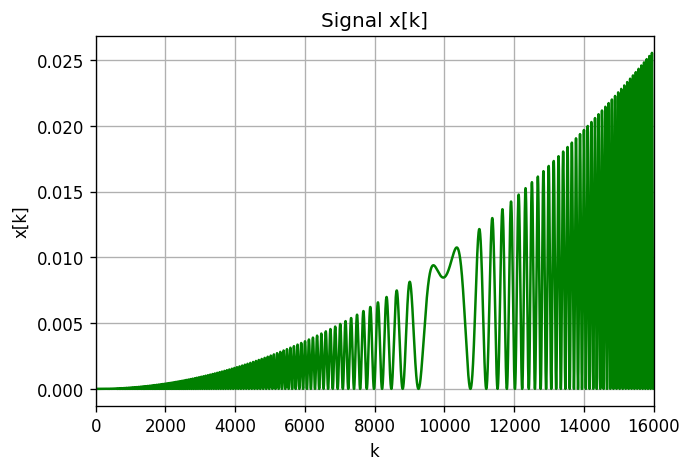

In [977]:
plot_signal0(sound, k_lim=16000)

In [978]:
def filter(wave, fs = 44100, f = 4, phase_coef = 0):
    limit = len(wave)
    k = np.arange(limit) / fs
    filt = 0.5 * (np.sin(k * 2 * np.pi * f - 2 * np.pi * phase_coef) + 1)
    return wave * filt

def filter_2(wave, fs = 44100, f = 512, f_ext = 64, phase_coef = 0.25):
    limit = len(wave)
    k = np.arange(limit) / limit
    f_range = f * 0.5 * (np.sin(2 * np.pi * k * f_ext - 2 * np.pi * phase_coef) + 1)
    filt = np.zeros(limit)
    for i in range(limit):
        filt[i] = 0.2 * (np.sin(k[i] * 2 * np.pi * f_range[i]) + 1)
    return wave * filt

def filter_3(wave, fs = 44100, f_min = 2, f_max = 20, f_ext = 2, phase_coef = 0.25):
    limit = len(wave)
    duration_freq = limit / fs
    print(duration_freq)
    k = np.arange(limit) / fs
    phase = 2 * np.pi * phase_coef
#     f_range = f * 0.5 * (np.sin(2 * np.pi * k * duration_freq * f_ext - phase) + 1)
#     f_range = np.ones(limit) * duration_freq * f_min
    f_range = (f_min * np.ones(limit) + 0.5*(f_max-f_min)*(np.sin(np.pi*k * f_ext - phase) + 1))
    f_range_plot = (f_min * np.ones(limit) + 0.5*(f_max-f_min)*(np.sin(2 * np.pi*k * f_ext - phase) + 1))
    plot_signal0(f_range_plot, limit)
    filt = np.zeros(limit)
    for i in range(limit):
        filt[i] = 0.5 * (np.sin(2 * np.pi * i /fs * f_range[i]) + 1) # * duration_freq * f_ext
        filt[i] = 0.5 * (np.sin(2 * np.pi * f_range[i]) + 1) # * duration_freq * f_ext
    result = wave * filt
#     plot_signal0(result, limit)
    return result

In [979]:
file_name = 'test'
output = sf.SoundFile(f'./{file_name}.wav', 'w', samplerate=44100, channels=1)
output.write((sound))
Audio(f'./{file_name}.wav')